#Principal Component Analyis (PCA)
Let's play with PCA on some synthetic data first.

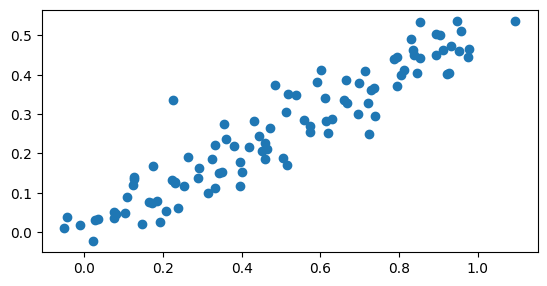

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Clean data along a line
x = np.arange(0,1,0.01)
y = x/2
X = np.vstack((x,y)).T
n = len(x)

#Add some noise
X = X + 0.05*np.random.randn(n,2)

#Plot data
plt.figure()
plt.scatter(X[:,0],X[:,1])
plt.gca().set_aspect('equal', adjustable='box')

The synthetic data is random data with a linear trend along the line $x=y$. Let's perform PCA to find the principal components of the data.

In [ ]:
def pca2D(X):
    """
    PCA function for 2D data

    Args:
        X: nx2 array of data

    Returns:
        Vals = amounts of variation in each principal direction, largest first
        Mean = centroid of the data
        P = principal components of variation, as columns of matrix P
    """

    #Compute Covariance Matrix
    Mean = np.mean(X,axis=0)
    cov_matrix = (X-Mean).T@(X-Mean)/X.shape[0]

    #Compute eigenvalues Vals and eigenvectors P of covariance matrix
    Vals, P = np.linalg.eigh(cov_matrix)

    #Reverse order so largest is first
    Vals = Vals[[1,0]]
    P = P[:,[1,0]]

    return Vals,Mean,P

Vals,Mean,P = pca2D(X)

print('The principal components are the columns of the matrix')
print(P)
print('The amount of variation captured by each component is given by the eigenvalues')
print(Vals)
print(Vals[0]/(Vals[0] + Vals[1]))

The principal components are the columns of the matrix
[[-0.89447722  0.44711352]
 [-0.44711352 -0.89447722]]
The amount of variation captured by each component is given by the eigenvalues
[0.10818319 0.00221994]
0.9798924091051217


Let's plot the principal components, with length given by the amount of variation. First we'll write a function for plotting, that we will call often later on.

In [ ]:
#Creates a visualization of PCA
def pca_plot(X,Vals,Mean,P,padding=0.25):
    """
    Creates a plot of 2D PCA, showing the principal component vectors
    properly scaled

    Args:
        X: Data points as mxn array
        Vals: Eigenvalues of Covariance Matrix
        Mean: Mean of data
        P: Matrix with Principal Components as columns
        padding: Fraction of padding to add to sides of plot

    Returns:
        No return, just creates plot
    """

    #Simpler variable names
    x = X[:,0]; y = X[:,1]

    #Length of arrows: 2 standard deviations contains 95% of data
    s1 = 2*np.sqrt(Vals[0])
    s2 = 2*np.sqrt(Vals[1])

    #Create large figure and scatter points
    plt.figure(figsize=(10,10))
    plt.scatter(x,y)

    #Plot arrows
    plt.arrow(Mean[0],Mean[1],s1*P[0,0],s1*P[1,0], head_width=0.025, color='red')
    plt.arrow(Mean[0],Mean[1],s2*P[0,1],s2*P[1,1], head_width=0.025, color='red')

    #Change xlim and ylim to add some extra padding to figure
    plt.xlim([x.min()-padding*(x.max()-x.min()),x.max() + padding*(x.max()-x.min())])
    plt.ylim([y.min()-padding*(y.max()-y.min()),y.max() + padding*(y.max()-y.min())])

    #Set axes to be equal units
    plt.gca().set_aspect('equal', adjustable='box')

Now let's plot the reuslts of PCA using our function.

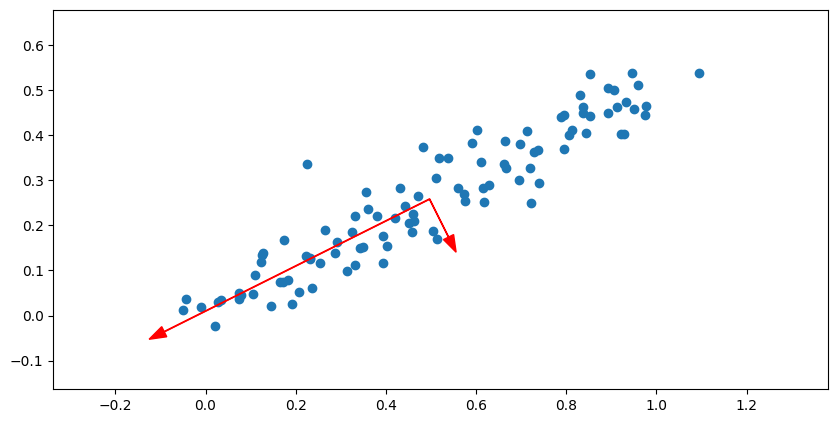

In [ ]:
pca_plot(X,Vals,Mean,P)

# Eigendigits

Let's run PCA on the MNIST dataset to see an application to real data. We will use the [Graph Learning](https://github.com/jwcalder/GraphLearning) package often in the course, it can be installed in Colab with pip, as below.



In [ ]:
pip install -q graphlearning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


(70000, 784)


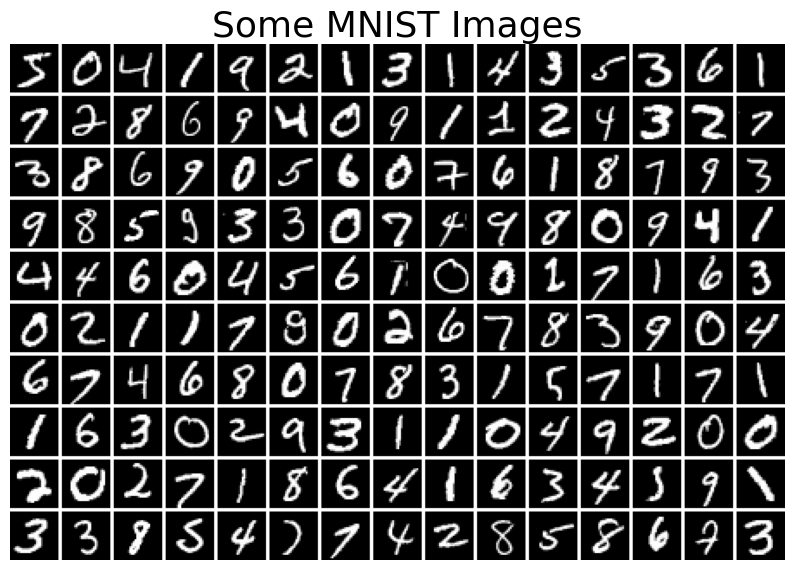

In [ ]:
import graphlearning as gl

data, labels = gl.datasets.load('mnist')
print(data.shape)
gl.utils.image_grid(data, n_rows=10, n_cols=15, title='Some MNIST Images', fontsize=26)

Let's find the top principal components of the MNIST dataset.

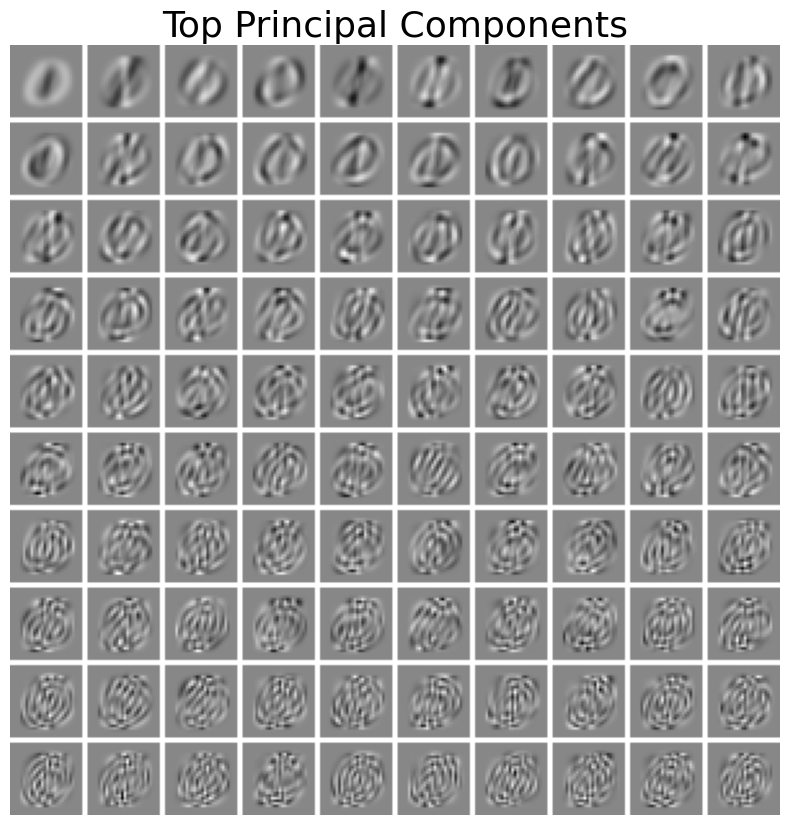

In [ ]:
from scipy import sparse
import numpy as np

ind = labels <=1
#Centered covariance matrix
X = data[ind,:] - np.mean(data[ind,:],axis=0)
S = X.T@X

#Use eigsh to get subset of eigenvectors
#('LM'=largest magnitude, k=200 eigenvectors)
vals, vecs = sparse.linalg.eigsh(S, k=100, which='LM')
vals, P = vals[::-1], vecs[:,::-1] #Returns in opposite order

#Display the top principal component images
gl.utils.image_grid(P.T, n_rows=10, n_cols=10, title='Top Principal Components', fontsize=26, normalize=True)

It's hard to see anything here. Let's run PCA on each class instead.

In [ ]:
num_comps = 10  #Number of PCA components
m = data.shape[1] #Number of pixels per image
k = len(np.unique(labels)) #Number of classes

#Arrays to store all principal components, and means for each class
Means = np.zeros((k,m))
P = np.zeros((k,m,num_comps))

#Loop over all digits
print("Computing PCA with %d components on each class..."%num_comps)
for i in range(k):
    print('Class %d'%i)

    #Extract images from class i
    X = data[labels==i,:]

    #Mean image and centered data
    X_mean = np.mean(X,axis=0)
    Y = X - X_mean

    #Main eigenvector/eigenvalue computation
    E, Pi = sparse.linalg.eigsh(Y.T@Y,k=num_comps,which='LM') #Principal components

    #Store PCA data into arrays
    P[i,:,:] = Pi[:,::-1]
    Means[i,:] = X_mean

Computing PCA with 10 components on each class...
Class 0
Class 1
Class 2
Class 3
Class 4
Class 5
Class 6
Class 7
Class 8
Class 9


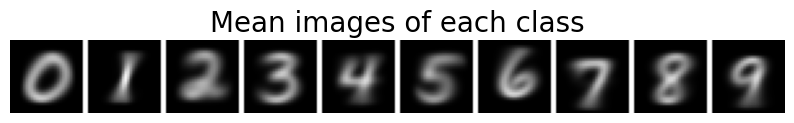

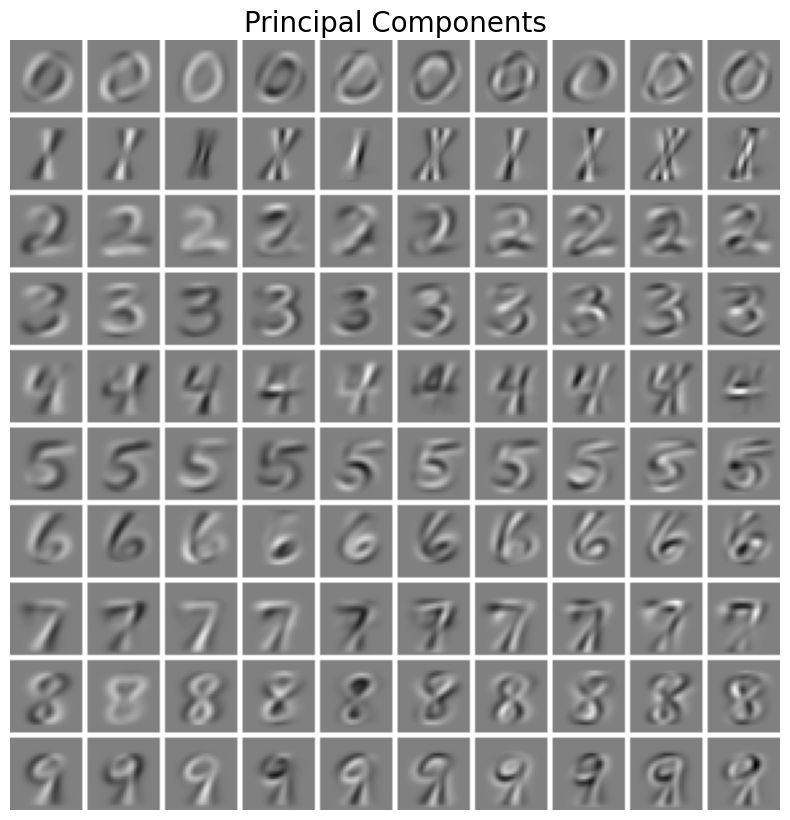

In [ ]:
gl.utils.image_grid(Means,n_rows=1,n_cols=k,title='Mean images of each class', fontsize=20)
gl.utils.image_grid(np.swapaxes(P[:,:,:min(10,num_comps)],1,2),title='Principal Components',normalize=True, fontsize=20)

# Eigenfaces

Let's do the same thing on a facial recognition dataset.



downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
(400, 4096)
(400,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


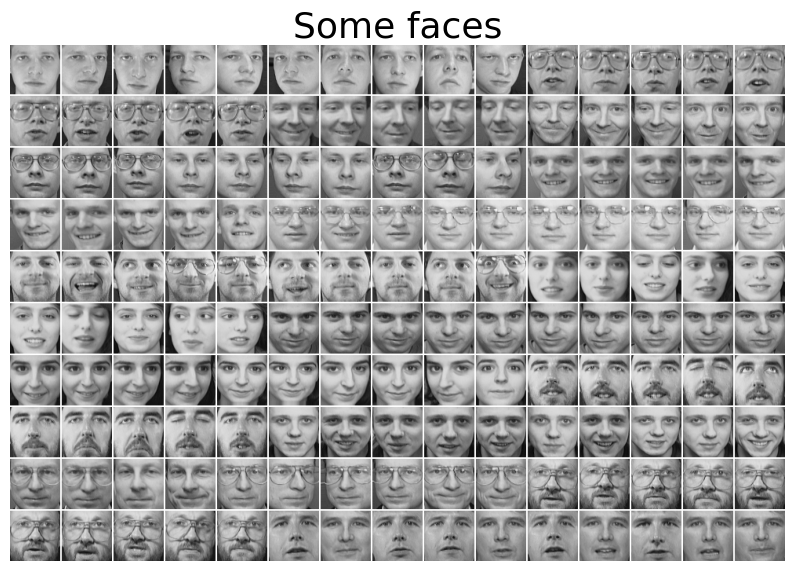

In [ ]:
import graphlearning as gl
from sklearn import datasets

ds = datasets.fetch_olivetti_faces()
data = ds['data']
labels = ds['target']

gl.utils.image_grid(data, n_rows=10, n_cols=15, title='Some faces', fontsize=26)
print(data.shape)
print(labels.shape)
print(np.unique(labels))

Let's run PCA on the face images, often called eigenfaces.

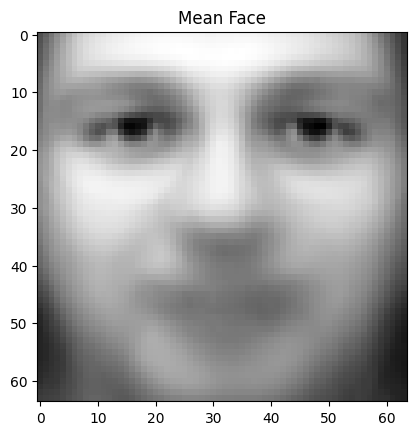

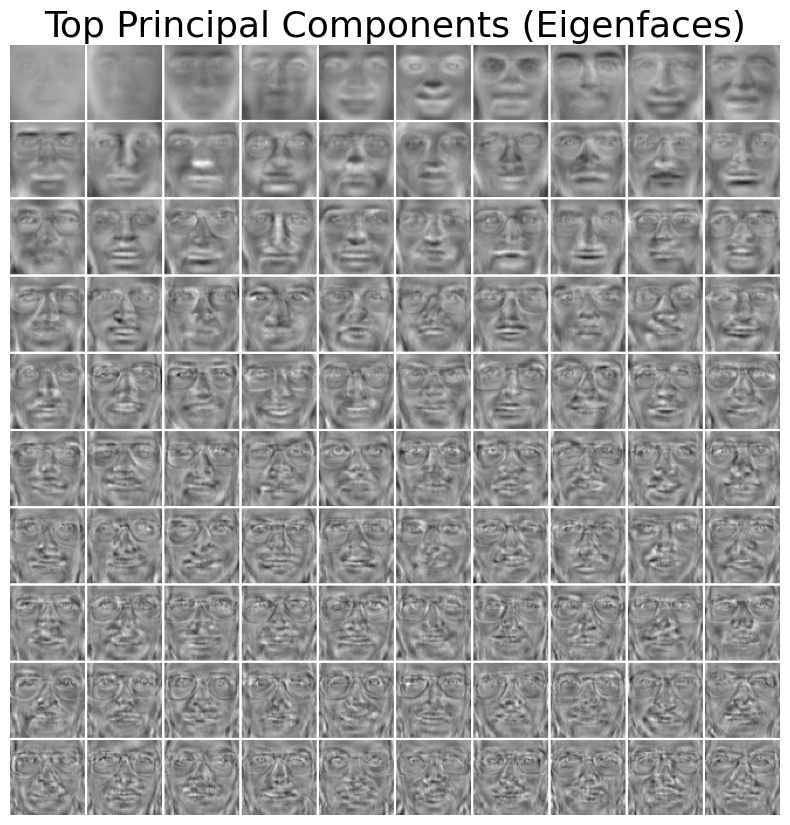

In [ ]:
import matplotlib.pyplot as plt

#Centered covariance matrix
mean_face = np.mean(data,axis=0)
X = data - mean_face
M = X.T@X

#Use eigsh to get subset of eigenvectors
#('LM'=largest magnitude, k=200 eigenvectors)
vals, vecs = sparse.linalg.eigsh(M, k=100, which='LM')
vals, P = vals[::-1], vecs[:,::-1] #Returns in opposite order

#Display the top principal component images
m = int(np.sqrt(len(mean_face)))
plt.imshow(np.reshape(mean_face,(m,m)),cmap='gray')
plt.title('Mean Face')
gl.utils.image_grid(P.T, n_rows=10, n_cols=10, title='Top Principal Components (Eigenfaces)', fontsize=26, normalize=True, transpose=False)

##Lack of robustness to outliers
PCA can be very sensitive to outliers. Even a single outlying point can have a dramatic effect.

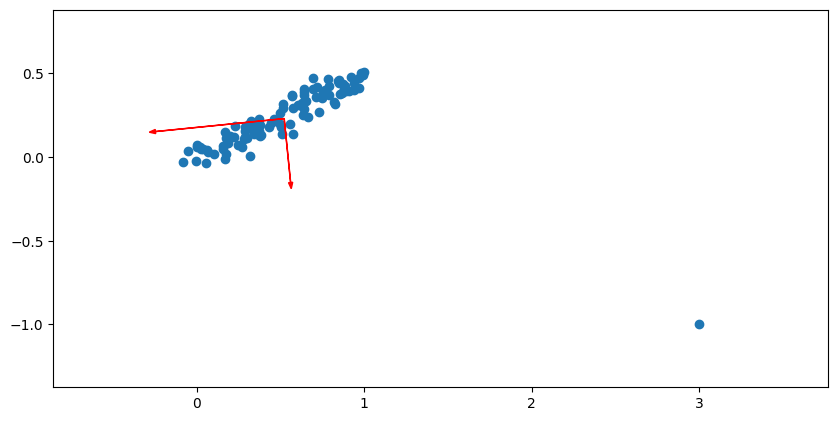

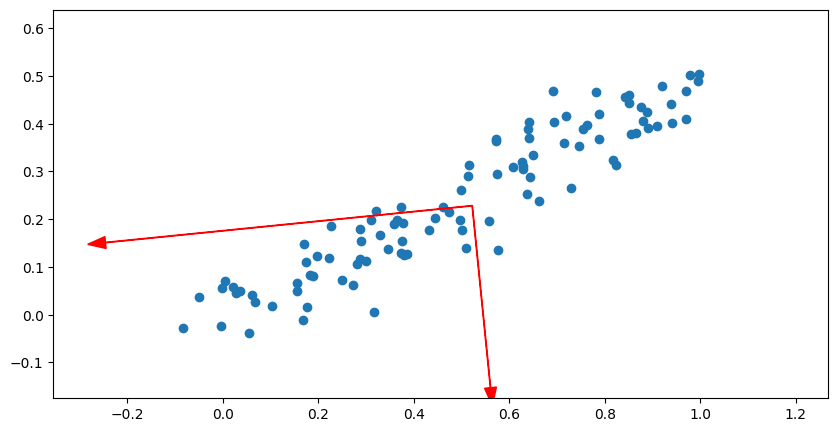

In [ ]:
#Clean data along a line
x = np.arange(0,1,0.01)
y = x/2
X = np.vstack((x,y)).T
n = len(x)

#Add some noise
X = X + 0.05*np.random.randn(n,2)

#Add an extra point at (-3,1) to the dataset
Y = np.vstack((X,[3,-1]))

#Recompute PCA and plot
Vals,Mean,P = pca2D(Y)
pca_plot(Y,Vals,Mean,P)

#Plot without the extra point, to zoom in
pca_plot(Y[:-1,:],Vals,Mean,P)

##Exercises

1. Try omitting the centering step in PCA, how do things change?
2. Add some outlying images to the face or image dataset. For example, take just the zero class in MNIST and add 1 (or a handful) of random face images. How do the principal components change?
3. Take a couple MNIST digits, say 0 and 1, and perform PCA to find the top 2 principal components. Then scatter plot the projection $Y=XP\in \mathbb{R}^{m\times 2}$ as a point cloud in the plane, with each point colored by its class label (`plt.scatter(Y[:,0],Y[:,1],c=labels)`)  
4. Try running a clustering algorithm, like k-means from sklearn, to cluster the 2D PCA data $Y$ from part 2.
5. Map the 2D PCA data back to the original 784 dimensional space with $P^T$, and plot the images. What do they look like? This is related to image compression, which we'll talk about next as an application of PCA.


In [ ]:
import numpy as np

X = np.array([[1,2],[3,4]])
Y = np.array([1,2])
print(X)
print(Y)
print(Y[:,None])
print(Y[None,:])

[[1 2]
 [3 4]]
[1 2]
[[1]
 [2]]
[[1 2]]
